# Условие

Дана функция $f(x)=a\tan(x)+(b\sin(x)+c\cos(x))^2+d\sqrt{x}$ и выборка $x,f(x)$ размера $10\leq n\leq1000$. Необходимо найти коэффициенты при условии, что они неотрицательные.

# Решение

## Градиентный спуск

Если бы не ограничения, мы могли бы решить эту задачу обычной линейной регрессией. Однако теперь нам надо как-то модифицировать решение. Для этого есть 4 способа.

-----
**1. Проекция на допустимую область**

**Как работает:**
* После каждого шага спуска можно проектировать коэффициенты на допустимую область. То есть, если после шага $a<0$, то просто сделаем его вручную $a=0$, или в общем $\Theta_{new}:=\max(\Theta_{new}, 0)$

**Преимущества:**
* Простота реализации.
* Гарантированное выполнение ограничений на каждом шаге.
* Подходит для задач с простыми ограничениями, например, как эта задача.

**Недостатки:**
* Проекция может замедлять сходимость. Когда решение близко к границе, проекция может постоянно сбрасывать коэффиценты к границе, замедляя алгоритм. А в многомерных задачах может приводить к зацикливанию у границы из-за колебаний при перепрыгивании границы.
* Сложности при конфликтующих ограничениях, например, $a,b\geq0$ и $a+b\leq1$.
* Сложности с вычислением сложных ограничений, например $sin(a)<b\cos(c)$.
* Не учитывает информацию о градиенте у границы.

-----
**2. Преобразование коэффициентов (логарифмическое преобразование)**

**Как работает:**
* Обычная замена коэффциентов на что-то другое, что автоматически учитывает ограничения. Например, в этой задаче $a=e^u$ и аналогично для других коэффициентов. И искать будем $u$ и прочие замены, на которые ограничений уже нет. Экспонента неотрицательна, значит исходные коэффициенты будут неотрицательны тоже.

**Преимущества:**
* Автоматическое учитывание ограничений. Конкретно это преобразование работает в задачах с неотрицательными коэффициентами.

**Недостатки:**
* Возможна численная нестабильность, так как экспонента может сильно расти, и тогда значения функции и ее градиента будут сильно расти при большой скорости обучения. Или наоборот, когда $a\approx0$, ведь тогда $u\to-\infty$.
* Градиент становится чувствительным к новым переменным $u$ и другим, что может затруднить подбор скорости обучения.

-----
**3. Регуляризация**

**Как работает:**
* Просто вводится штраф в стиле L1 и L2 регуляризаций в функцию ошибки: $L'(\Theta)=L(\Theta)+\lambda\sum_{\theta\in\Theta}\max(0,-\theta)^2$. Возводить в квадрат штраф не обязательно, так мы просто делаем это слагаемое гладким, в отличии от линейного штрафа, и сильнее штрафуем за нарушение ограничения.

**Преимущества:**
* Не нужно менять градиентный спуск.
* Подходит для любых ограничений. Например, $a^2+b^2\leq1$. Достаточно представить штраф как $\max(0,a^2+b^2-1)$. С той же проекцией это уже сложнее, например, когда $a^2,b^2>0.5$ - непонятно что проецировать: $a^2=1-b^2$ или $b^2=1-a^2$.

**Недостатки:**
* Параметры могут выходить за границы ограничений, если $\lambda$ мал. А если велик, то может замедлить сходимость.

-----
**4. Отражение градиента**

**Как работает:**
* При указании градиента в недопустимую область, отражаем его обратно, то есть делаем $grad:=-grad$.

**Преимущества:**
* Сохраняет движение вдоль границы ограничений.

**Недостатки:**
* Сложно обобщить на многомерный случай.
* Плохо работает при сложной форме области значений.

-----
**Когда и что использовать:**
* Проекцию, когда ограничения простые, так как он кажется самым безопасным способом.
* Логарифмическое преобразование, когда задача чувствительна к численной стабильности, то есть имеется гарантия, что числа не устремятся в бесконечность.
* Регуляризацию, когда ограничения не такие строгие, а скорее желательны. Или когда ограничения сложные и их трудно учесть напрямую. Такие как: нелинейные зависимости ($a^2+b^2\leq1$), связанные ограничения ($ab\leq1$), целочисленные ограничения ($a,b\in Z$).
* Отражение кажется вообще использовать не надо.

-----
По итогу получается, что для нашей задачи самым неплохим методом выглядит проекция. Еще как-то может быть применимо логарифмическое преобразование. Совсем не подходит регуляризация, так как мы можем просто получить некорректный ответ, и с ним еще возиться с $\lambda$. А отражение просто звучит лично для меня странно.

## BFGS

# Код

## Градиентный спуск

In [69]:
import numpy as np

f = open('input.txt', 'w')
X = np.arange(20).reshape(-1, 1)
w = np.array([5, 2, 4, 1])
y = w[0] * np.tan(X) + (w[1] * np.sin(X) + w[2] * np.cos(X))**2 + w[3] * X**0.5
f.write(str(len(X)) + '\n')
for i in range(len(X)):
    f.write(str(X[i][0]) + ' ' + str(y[i][0]) + '\n')
f.close()

In [83]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from time import time

np.random.seed(42)

class MSE:
    def __init__(self):
        pass

    def loss(self, y, y_pred):
        return 1 / len(y) * (y_pred - y).T @ (y_pred - y)

    def grad(self, X, y, y_pred):
        return 2 / len(y) * X.T @ (y_pred - y)

class Adam:
    def __init__(self, W, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m = np.zeros_like(W)  # Первый момент (скользящее среднее градиентов)
        self.v = np.zeros_like(W)  # Второй момент (скользящее среднее квадратов градиентов)
        self.t = 0                 # Счетчик шагов
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def update(self, W, grad):
        # Обновление первого и второго моментов
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)
                    
        # Коррекция смещения
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
                    
        # Обновление весов
        return W - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

def gen_batches(X, y, size=10, tail=True):
    N = len(y)
    perm = np.random.permutation(N)
    for i in range(0, N, size):
        if tail or i + size <= N:
            yield X[perm[i:min(i+size,N)]], y[perm[i:min(i+size,N)]]

class LinearRegression:
    def __init__(self, loss_f):
        self.loss_f = loss_f

    def fit(self, X, y, lr=1e-3, optimizer='adam', epoch=10000):
        loss_history = []
        self.W = np.random.rand(X.shape[1], y.shape[1]) * 0.01
        opt = None
        if optimizer == 'adam':
            opt = Adam(self.W, lr)
        for e in range(epoch):
            avg_loss, n_batches = 0, 0
            for X_batch, y_batch in gen_batches(X, y, size=20):
                y_pred = self.predict(X_batch)
                loss = self.loss_f.loss(y_batch, y_pred)
                avg_loss += loss.item()
                n_batches += 1
                grad = self.loss_f.grad(X_batch, y_batch, y_pred)
                self.W = opt.update(self.W, grad)
                self.W = np.clip(self.W, a_min=0, a_max=None)
            loss_history.append(avg_loss / n_batches)
        return loss_history

    def predict(self, X):
        return X @ self.W

f = open('input.txt')
n = int(f.readline())
data = np.array([[float(x) for x in f.readline().split()] for i in range(n)])
f.close()
X, y = data[:, 0], data[:, 1].reshape(-1, 1)
X = np.array([np.tan(X), (np.sin(X))**2, 2*np.sin(X)*np.cos(X), (np.cos(X))**2, X**0.5]).T
model = LinearRegression(MSE())
loss_history = model.fit(X, y, lr=1e-3, optimizer='adam')
print(model.W[0, 0], model.W[1, 0]**0.5, model.W[3, 0]**0.5, model.W[4, 0])

0.0005451577456679418 0.990134321779461 1.9938428361425227 3.009046750088107
1.9741722242988138 1.9996205018102475


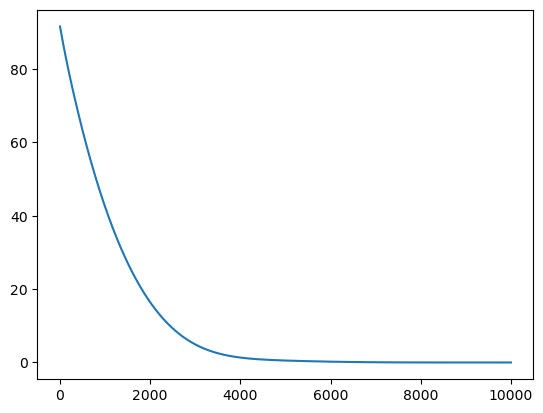

In [84]:
from matplotlib import pyplot as plt

plt.plot(np.arange(len(loss_history)), loss_history)

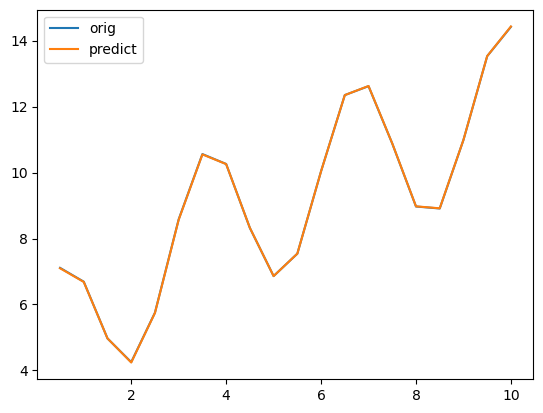

In [81]:
plt.plot(data[:, 0], data[:, 1].reshape(-1, 1), data[:, 0], model.predict(X))
plt.legend(['orig', 'predict'])

## BFGS

In [ ]:
import numpy as np



In [66]:
import numpy as np
from scipy.optimize import minimize

# Функция f(x) с параметрами a, b, c, d
def f(x, a, b, c, d):
    return a * np.tan(x) + (b * np.sin(x) + c * np.cos(x))**2 + d * np.sqrt(x)

# Целевая функция для минимизации
def loss_function(params, x_values, f_values):
    a, b, c, d = params
    predicted_f = f(x_values, a, b, c, d)
    return np.sum((predicted_f - f_values)**2)

# Чтение входных данных
file = open('input.txt')
n = int(file.readline())
data = [list(map(float, file.readline().split())) for _ in range(n)]
file.close()
x_values = np.array([x for x, _ in data])
f_values = np.array([f_val for _, f_val in data])

# Начальные предположения для коэффициентов
initial_guess = [1.0, 1.0, 1.0, 1.0]

# Ограничения: все коэффициенты >= 0
bounds = [(0, None), (0, None), (0, None), (0, None)]

# Минимизация целевой функции
result = minimize(
    loss_function,
    initial_guess,
    args=(x_values, f_values),
    bounds=bounds,
    method='L-BFGS-B'
)

# Извлечение найденных коэффициентов
a, b, c, d = result.x
print(f"{a:.6f} {b:.6f} {c:.6f} {d:.6f}")

0.000098 0.999363 2.000002 2.999901
